In [1]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
import cv2
from shapely.geometry import Polygon
from PIL import ImageDraw, Image

In [2]:
model = YOLO('./runs/segment/train14/weights/last.pt')

In [11]:
model.train(
    data='/mnt/c/Users/egorn/Desktop/dataset_yolo/triseg/wdp-yolo.yaml',
    optimizer='AdamW',
    epochs=1001,
    imgsz=640,
    batch=7,
    patience=500,
    save_period=100,
    single_cls=False,
    cos_lr=True,
    lr0=1e-4,
    lrf=1e-2,
    weight_decay=5e-5,
    warmup_epochs=50,
    amp=False,
    # hsv_h=0,
    # hsv_s=0,
    # hsv_v=0,
    degrees=0.1,
    # translate=0,
    scale=0.25,
    shear=0,
    perspective=0,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0,
    mixup=0,
    copy_paste=0,
    mask_ratio=1,
    overlap_mask=False,
    cache='ram',
    resume=False,
    dfl=3,
    box=4,
    pretrained=True,
)

New https://pypi.org/project/ultralytics/8.0.157 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.9.17 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train13/weights/last.pt, data=/mnt/c/Users/egorn/Desktop/dataset_yolo/triseg/wdp-yolo.yaml, epochs=1001, patience=500, batch=7, imgsz=640, save=True, save_period=100, cache=ram, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, overlap_mask=False, mask_ratio=1, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, l

In [60]:
res = model('/mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4', conf=0.3, stream=True)

pic_size = (480, 640, 3)
frameSize = (640, 480)

folder = Path('/mnt/c/Users/egorn/Desktop/new_vids/1.16_frames')
folder.mkdir(exist_ok=True)


out = cv2.VideoWriter((folder / 'video.mp4').as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), 5, frameSize)

for i, frame in enumerate(res):
    classes = frame.boxes.cls
    
    color_pic = np.zeros(pic_size, dtype=np.uint8)

    if len(classes):
        masks = frame.masks.data
        for cls_id, cls in enumerate(classes):
            single_mask = masks[cls_id]
            pic_channel = (single_mask == 1).cpu().numpy().astype(dtype=np.uint8) * 255
            color_pic[..., int(cls)] = pic_channel
    
    cv2.imwrite((folder / f'frame_{i}.png').as_posix(), color_pic[..., ::-1])
    out.write(frame.plot())

out.release()


video 1/1 (1/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 176.3ms
video 1/1 (2/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 23.5ms
video 1/1 (3/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 7.3ms
video 1/1 (4/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 9.3ms
video 1/1 (5/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 8.7ms
video 1/1 (6/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 7.4ms
video 1/1 (7/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 8.8ms
video 1/1 (8/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 21.6ms
video 1/1 (9/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 7.9ms
video 1/1 (10/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 480x640 1 big, 7.9ms
video 1/1 (11/116) /mnt/c/Users/egorn/Desktop/new_vids/videos/1.16.mp4: 48

In [42]:
frame.boxes.cls

tensor([0., 1.], device='cuda:0')

In [26]:
def mask_to_polygons(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # mask = mask[..., 1]
    if mask.sum() < 10:
        return None, None

    mask = mask.astype(bool)

    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    normalized_polygons = []
    for contour in contours:
        try: 
            polygon = contour.reshape(-1, 2).tolist()
            # normalized_polygon = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in polygon]
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.999, preserve_topology=True)
            simplified_polygon_norm = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in simplified_polygon.exterior.coords]
            polygons.append(simplified_polygon)
            normalized_polygons.append(Polygon(simplified_polygon_norm))
        except Exception as e:
            pass

    return polygons, normalized_polygons

In [48]:
root_dir = Path('/mnt/c/Users/egorn/Desktop/dataset_yolo/triseg')
txt_dir = root_dir / 'label'
mask_dir = root_dir / 'mask'
img_dir = root_dir / 'original'

In [49]:
# for img in img_dir.glob('*.png'):
#     new_name = img.name.split('_original')[0] + '.png'
#     img.rename(img.parent / new_name)

In [50]:
im = Image.new('L', (640,480), 0)
draw = ImageDraw.Draw(im)

for mask in mask_dir.glob('*1.13_frame_30_combmask.png'):
    poly, norm_poly = mask_to_polygons(mask.as_posix())
    txt_path = txt_dir / (mask.name.split('_mask')[0] + '.txt')
    points_str = '0'
    for point in norm_poly[0].exterior.coords:
    
        x, y = point
        points_str += f' {x} {y}'
        draw.ellipse((x * im.size[0] - 1, y * im.size[1] - 1 ,  x * im.size[0] + 1,  y * im.size[1] + 1), fill=255)

    # txt_path.write_text(points_str)
    break
    # draw.ellipse((x - 1, y - 1 ,  x + 1,  y + 1), fill=255)    

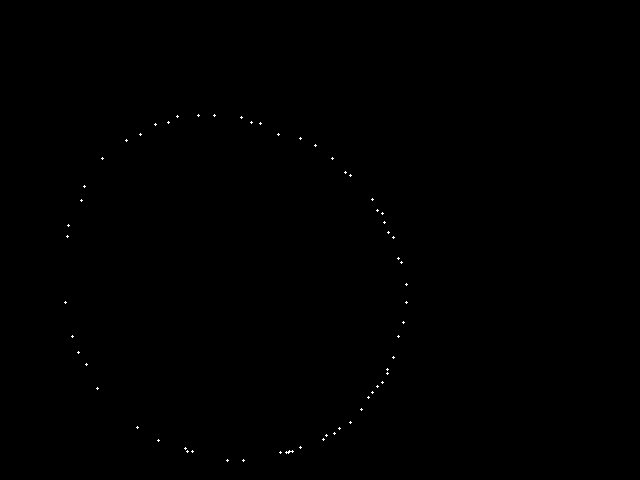

In [51]:
im

In [14]:
root_dir = Path('/mnt/c/Users/egorn/Desktop/new_vids/')
new_root_dir = Path('/mnt/c/Users/egorn/Desktop/dataset_yolo/')

txt_dir = root_dir / 'label'
mask_dir = root_dir / 'mask'
orig_dir = root_dir / 'original'

In [16]:
# im = Image.new('L', mask.size, 0)
# draw = ImageDraw.Draw(im)

# for mask in mask_dir.glob('*.png'):
#     new_name = mask.name.split('_')[0] + '_' + mask.name.split('_')[2]
#     mask.rename(mask.parent / (new_name + '_mask.png'))

# for orig in orig_dir.glob('*.png'):
#     new_name = orig.name.split('_')[0] + '_' + orig.name.split('_')[2]
#     orig.rename(orig.parent / (new_name + 'original.png'))


for mask in mask_dir.glob('*.png'):
    poly, norm_poly = mask_to_polygons(mask.as_posix())
    if poly is None:
        continue
    points_str = '0'
    for point in norm_poly[0].exterior.coords:
        x, y = point
        points_str += f' {x} {y}'

    txt_path = new_root_dir / 'new_vids' / (mask.stem.split('_mask')[0] + '.txt')
    txt_path.write_text(points_str)
    src_img_path = mask.parent.parent / 'original' / (mask.stem.split('_mask')[0] + 'original.png')
    img_path = new_root_dir / 'new_vids' / (mask.stem.split('_mask')[0] + '.png')
    img_path.write_bytes(src_img_path.read_bytes()) 

    # # draw.ellipse((x * mask.size[0] - 1, y * mask.size[1] - 1 ,  x * mask.size[0] + 1,  y * mask.size[1] + 1), fill=255)
    # draw.ellipse((x - 1, y - 1 ,  x + 1,  y + 1), fill=255)
    

In [14]:
list(norm_poly[0].exterior.coords)

[(0.35, 0.3375),
 (0.2875, 0.3583),
 (0.25, 0.3792),
 (0.2234, 0.4021),
 (0.2016, 0.4292),
 (0.1719, 0.5292),
 (0.1656, 0.5938),
 (0.1734, 0.6521),
 (0.2062, 0.7333),
 (0.2547, 0.7937),
 (0.2844, 0.8146),
 (0.3125, 0.8292),
 (0.35, 0.8396),
 (0.3953, 0.8417),
 (0.4219, 0.8333),
 (0.4703, 0.8083),
 (0.5078, 0.7583),
 (0.5297, 0.7167),
 (0.5469, 0.6646),
 (0.5531, 0.6146),
 (0.55, 0.5708),
 (0.5422, 0.5125),
 (0.5359, 0.4917),
 (0.5078, 0.4313),
 (0.4891, 0.4),
 (0.4453, 0.3625),
 (0.4109, 0.3438),
 (0.3906, 0.3396),
 (0.35, 0.3375)]

In [5]:
mask.size

(640, 480)

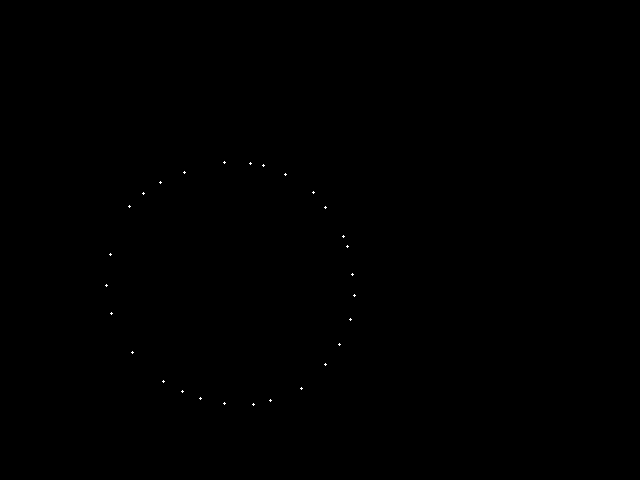

In [6]:
im

In [17]:
model = YOLO('yolov8n-seg.pt')

NameError: name 'YOLO' is not defined